# Quantum machine learning in Amazon Braket Hybrid Jobs

This notebook demonstrates a typical quantum machine learning workflow, including uploading data, monitoring training, and tuning hyperparameters. We focus on training a parameterized quantum circuit for an unsupervised generative modelling task.


## Learning outcomes

* Set input data 
* Set hyperparameters 
* Submit multiple hybrid jobs asynchronously 
* Monitor hybrid job progress via the AWS Console 
* Download and plot results

## Background: Generative modelling 

Generative modelling is an unsupervised learning task where the goal is to generate new synthetic samples from an unknown target probability distribution. We denote the target probability distribution as $p(x)$, and the estimated distribution as $p_{\theta}(x)$. The goal is to learn $p_{\theta}(x)$ that closely resembles the target $p(x)$.  One metric to quantify the difference between probability distributions is the maximum mean discrepancy (MMD) loss . 

$$MMD(x, y) = \sum_{j=1}^N \sum_{j'=1}^N k(y_j, y_{j'}) + \sum_{i=1}^N \sum_{i'=1}^N k(x_i, x_{i'})  - 2 \sum_{j=1}^N \sum_{i=1}^N k(y_j, x_i)$$
where $x$ is a sample from the target data $p(x)$, $y$ is a sample from the generative model $p_{\theta}(x)$, and $k$ is a Gaussian kernel

$$ k(x,y)= \sum_{\sigma} e^{-(x-y)^2/(2 \sigma^2))}$$

The MMD loss is zero if and only if $p(x)=p_{\theta}(x)$ for all $x$. 

Learning a good approximation $p_{\theta}$ depends on the expressibility of the model, the effectiveness of the training algorithm, and the ability to sample the circuit efficiently. 


## Quantum Circuit Born Machine 

Quantum circuits are a natural fit for generative modelling because they are inherently probabilistic; the wavefunction encodes a probability according to the Born rule:

$$p(x)=|\langle x|\psi\rangle|^2$$

In quantum mechanics, we do not have access to $p(x)$ directly, but we can efficiently sample using projective measurements [1]. This is an implicit generative model similar to generative adversarial networks (GANs). Quantum circuits allow fast sampling from a high-dimension distribution, and have large expressive power. 

The QCBM in this tutorial consists of alternating layers of single qubit rotations ($RX, RZ, RX$), followed by an entangling layer of CNot gates on each neighboring qubits. The final measurement layer computes the bit string samples of each outcome. Run the cell below to print a circuit diagram of a QCBM with randomly initialized parameters.


In [1]:
import numpy as np

from braket.devices import LocalSimulator
from qcbm.qcbm import QCBM


n_qubits = 3
n_layers = 2

init_params = np.random.rand(3 * n_layers * n_qubits)
device = LocalSimulator()
qcbm = QCBM(device, n_qubits, n_layers, np.random.rand(1))
print(qcbm.create_circuit(init_params))

T  : |   0    |   1    |   2    |3|4|    5     |   6    |   7    |   8    |9|10|11|Result Types|
                                                                                                
q0 : -Rx(0.53)-Rz(0.86)-Rx(0.21)-C---X----------Rx(0.24)-Rz(0.41)-Rx(0.88)-C----X--Probability--
                                 |   |                                     |    |  |            
q1 : -Rx(0.27)-Rz(0.55)-Rx(0.22)-X-C-|-Rx(0.65)-Rz(0.26)-Rx(0.95)----------X-C--|--Probability--
                                   | |                                       |  |  |            
q2 : -Rx(0.92)-Rz(0.97)-Rx(0.43)---X-C----------Rx(0.25)-Rz(0.42)-Rx(0.98)---X--C--Probability--

T  : |   0    |   1    |   2    |3|4|    5     |   6    |   7    |   8    |9|10|11|Result Types|


## Problem setup

This notebook demonstrates training a QCBM on a toy data set using Amazon Braket Hybrid Jobs. The code for the QCBM is in `qcbm` directory. The `qcbm_job.py` contains the code that will run when we create a Braket Hybrid Job. The other file (`qcbm.py`) contain the source code for the QCBM. 

In this tutorial, we use a small number of qubits to make it quick to test the algorithm. We use the on-demand simulator SV1 to run our circuits and gradient calculations in parallel (up to 35 concurrent tasks).  

We first set the number of qubits we want to use in our problem:

In [2]:
n_qubits = 5

## Generate data

As an example, we consider the toy example of learning a mixture of Gaussian distributions. We set a numpy random seed to produce the same data each time, but try experimenting with the number of peaks and number of qubits to produce harder or easier data sets. For this example, the target distribution $p(x)$ is a Gaussian on 5 bits (so $2^5$ possible values), with peaks at $\mu_1=7$ and $\mu_2=20$, with standard deviations $\sigma_1=1$, $\sigma_2 = 2$. We generate and plot the data as a probability density function in the cell below.

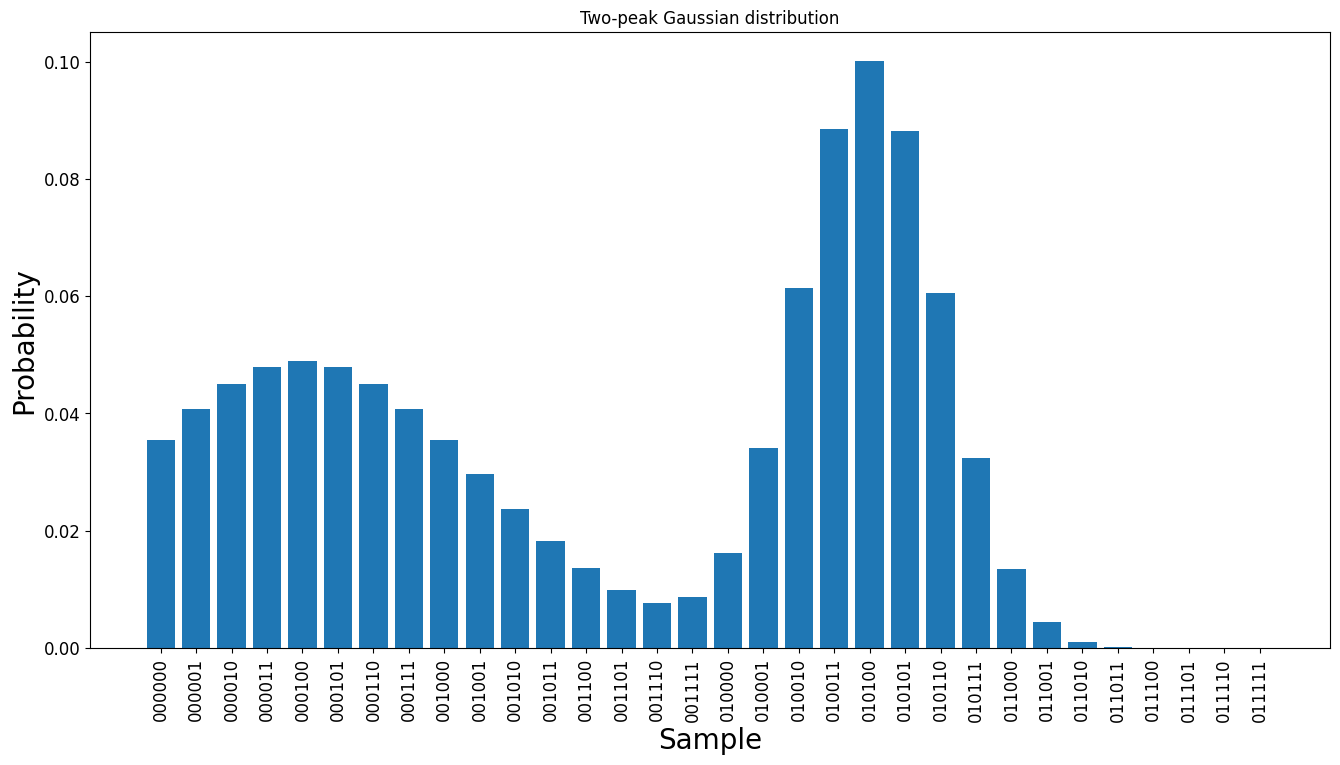

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

def gaussian(n_qubits, mu, sigma=1):
    x = np.arange(2 ** n_qubits)
    gaussian = (
        1.0
        / np.sqrt(2 * np.pi * sigma ** 2)
        * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))
    )
    return gaussian / sum(gaussian)


data = gaussian(n_qubits, mu=4, sigma=5) + gaussian(n_qubits, mu=20, sigma=2)
data = data / sum(data)


labels = ["{0:{fill}6b}".format(i, fill='0') for i in range(len(data))]

plt.bar(range(2 ** n_qubits), data)
plt.xticks([i for i in range(len(data))], labels, rotation='vertical', size=12)
plt.yticks(size=12)

plt.xlabel("Sample", size=20)
plt.ylabel("Probability", size=20)
plt.title("Two-peak Gaussian distribution")

fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.show()

In [4]:
np.save("data.npy", data) # save data to file

## Training  


Next, we train the circuit using the [limited-memory BFGS](https://en.wikipedia.org/wiki/Limited-memory_BFGS) optimizer from scipy. 
Instead of using finite-difference gradients, we use the exact MMD loss function gradient. 

The training function has three arguments that act as hyperparameters: number of qubits `n_qubits`, number of layers in the QCBM `n_layers`, and the number of iterations in the optimization algorithm. 
The number of layers determines how many rotation angles are in the quantum circuit. 
For the QCBM, we need `n_params = 3 * n_layers * n_qubits` parameters. 


Since we will eventually run this training function as an hybrid job, we add three convenience functions. 
Firstly, we use `log_metric` to print the loss function for each iteration. 
Once we run this as a hybrid job, the metrics will be displayed in near-real time on the Braket console, or via [Amazon CloudWatch](https://aws.amazon.com/cloudwatch/). 

Secondly, we write our results to a file prefixed with the path `get_results_dir()`. 
This is necessary because hybrid jobs use a temporary filesystem.
Once the instance is terminated, all files on the instance are deleted.

Lastly, the return statement of the function will be our hybrid job results returned by `job.result()`. 
These can be a single object or a dictionary with string keys. 
Note that while most native Python objects are supported, custom classes that do have have defined serialization methods may not work. 
For example, we can return the numpy array of final parameters, but we cannot return the QCBM object itself. 

In [5]:
from braket.tracking import Tracker
from scipy.optimize import minimize

from braket.jobs import get_results_dir
from braket.jobs.metrics import log_metric

from qcbm.qcbm import mmd_loss

def train_circuit(n_qubits, n_layers, n_iterations=10):
    global iteration_number
    iteration_number = 0
    
    braket_task_costs = Tracker().start()

    device = LocalSimulator()

    data = np.load("data.npy") # load the input data
    
    qcbm = QCBM(device, n_qubits, n_layers, data)
    
    init_params = np.random.rand(3 * n_layers * n_qubits)

    def callback(x):
        global iteration_number
        iteration_number += 1
        loss = mmd_loss(qcbm.probabilities(x), data)
        
        log_metric( # log the metrics to Braket console
            metric_name="loss",
            value=loss,
            iteration_number=iteration_number,
        )

    res = minimize(
        lambda x: mmd_loss(qcbm.probabilities(x), data),
        x0=init_params,
        method="L-BFGS-B",
        jac=lambda x: qcbm.gradient(x),
        options={"maxiter": n_iterations},
        callback=callback,
    )
    final_params = res.x

    # save final parameters
    np.save(get_results_dir() + "/final_params.npy", final_params)
    
    return {
            "params": final_params,
            "task summary": braket_task_costs.quantum_tasks_statistics(),
            "estimated cost": float(braket_task_costs.qpu_tasks_cost() + braket_task_costs.simulator_tasks_cost()),
        }


Now let's run the function to verify that it works as expected.

In [6]:
%%time

train_circuit(n_qubits, n_layers=n_layers, n_iterations=5)

Metrics - timestamp=1697028322.742037; loss=0.0738105584324629; iteration_number=1;
Metrics - timestamp=1697028324.6127226; loss=0.05514942674966222; iteration_number=2;
Metrics - timestamp=1697028328.4326718; loss=0.029347326432547782; iteration_number=3;
Metrics - timestamp=1697028330.5567336; loss=0.02751726243188396; iteration_number=4;
Metrics - timestamp=1697028332.750267; loss=0.019362259334110732; iteration_number=5;
CPU times: user 3.87 s, sys: 515 ms, total: 4.39 s
Wall time: 13.9 s


{'params': array([ 0.55196856,  0.38672791,  1.35300743,  0.87330452, -0.54221993,
         0.74465571,  0.61411241,  0.06143268,  0.81830411,  0.28084566,
         0.98187881,  0.17193621,  0.04322529,  0.02989581, -0.08170342,
         0.58622265,  0.50212177,  0.32964731,  1.19606685, -0.28772351,
         0.60482847, -0.04202664,  0.33609895,  0.12554622,  0.46006129,
         0.44578169,  1.22449628,  1.1830697 ,  0.19600585,  0.35640496]),
 'task summary': {},
 'estimated cost': 0.0}

Great! Now for longer algorithms, or those that require priority queueing to a QPU, we can run this function on AWS by adding the `@hybrid_job` annotation and calling the function.

## Training with hybrid jobs

Amazon Braket Hybrid Jobs provides fully managed execution of hybrid quantum-classical algorithms, combining AWS classical compute resources based on Amazon EC2 (the "job instance") with Amazon Braket quantum processing units (QPUs) or quantum circuit simulators. 

There are three arguments to the `@hybrid_job` decorator that we will use in this example. Firstly, 
since we do not require priority QPU access, we set `device=None` in the decorator arguments. 
This argument is responsible for scheduling the hybrid job to run on a QPU. 
In this example, we use the Braket local simulator running on the job instance. 
If we find this simulator too slow, we could either increase the the classical compute by selecting a larger instance, or switch to using on-demand Braket simulators like [SV1](https://docs.aws.amazon.com/braket/latest/developerguide/braket-devices.html#braket-simulator-sv1). 

Next, we include the source code for the QCBM with `include_modules`. This can be a Python module, directory, or file. We may also specify multiple modules with a list.

Lastly, as a quantum machine learning algorithm, the QCBM requires  training data. 
When you create a hybrid job, you may provide an input training datasets by specifying an Amazon Simple Storage Service (Amazon S3) bucket. 
You may also specify a local path, in which case Braket will automatically upload the data to Amazon S3 at `s3://<default_bucket_name>/jobs/<job_name>/data/<channel_name>`. 
In this example, we use the local data file `input_data="data.npy"`. You may specify multiple input datasets with a dictionary where the values are the paths to either S3 or local files. 

Now we run the training algorithm remotely as a hybrid job. 

In [7]:
from braket.jobs import hybrid_job

# For now, lets set local=False. This uses a local Docker container
@hybrid_job(device=None, local=False, include_modules="qcbm", input_data="data.npy")
def train_circuit_hybrid_job(n_qubits, n_layers, n_iterations):
    return train_circuit(n_qubits, n_layers, n_iterations)

In [8]:
%%time 

job = train_circuit_hybrid_job(n_qubits, n_layers=n_layers, n_iterations=10)
res = job.result()

CPU times: user 509 ms, sys: 30.4 ms, total: 540 ms
Wall time: 3min 52s


Great! We created our first quantum machine learning job! 

We can check the status of the hybrid job with 

In [9]:
job.state()

'COMPLETED'

We can also monitor the status of the hybrid job with the AWS Console.

<div align="center"><img src="console_figures/running_job.png"/></div>

Once it’s complete, we can grab the result with `job.result()` which will wait for the hybrid job to finish. In `qcbm_job.py`, we set the results to be the final parameters of the QCBM that minimized the loss function. Results are returned as a dictionary.

In [10]:
%%time 
job.result()

CPU times: user 10.4 ms, sys: 475 µs, total: 10.9 ms
Wall time: 341 ms


{'params': array([ 0.35736532,  0.31073256,  0.91610879,  0.98872712, -0.08082859,
         0.47862197,  0.68460835, -0.09855128,  0.90463028,  0.25120807,
         0.83142284,  0.42736354, -0.04195098,  0.69129029,  0.63572789,
         0.75008587,  0.63212422,  0.95159988,  0.78795069,  0.17262345,
         0.92826497,  0.75725417,  0.18248898,  0.80719954,  1.31568383,
         0.85844901,  0.5214184 ,  0.04987039,  0.03008104, -0.03636072]),
 'task summary': {},
 'estimated cost': 0.0}

Awesome! Our first quantum machine learning job finished! Now let’s look at the training metrics.

Note that due to the inherent randomness in the training process, running this example repeatedly may yield different results each time.

## Metrics and plotting

In the `qcbm_job.py` script, we monitored the loss function during training with 
```
log_metric(
    metric_name="loss",
    value=loss,
    iteration_number=iteration_number,
)
```
Metrics recorded in this way are visible from the "Monitor" tab in the AWS Console. It will look similar to the below image:

<div align="center"><img src="console_figures/metrics.png"/></div>

Metrics are also available by calling `job.metrics()`. Using pandas, and matplotlib, we plot the convergence of the loss below. 

<Axes: xlabel='iteration_number'>

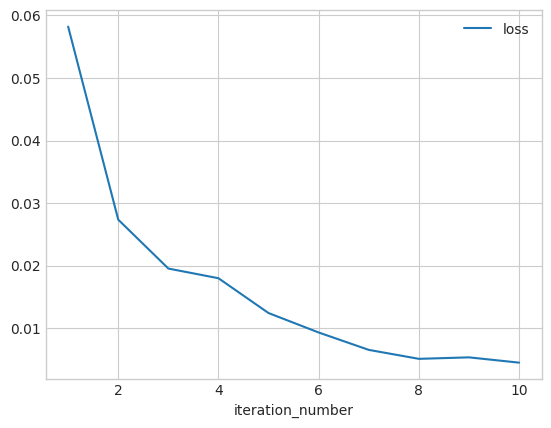

In [19]:
# Plotting the convergence of the loss function metric
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use("seaborn-v0_8-whitegrid")


df = pd.DataFrame(job.metrics())
df.sort_values(by=["iteration_number"]).plot(x="iteration_number", y="loss")

Importantly, we can plot the predicted probability distribution vs the target probability from the data. 
To do so, we first import the QCBM locally again, but now we initialize it with the parameters returned from our hybrid job.

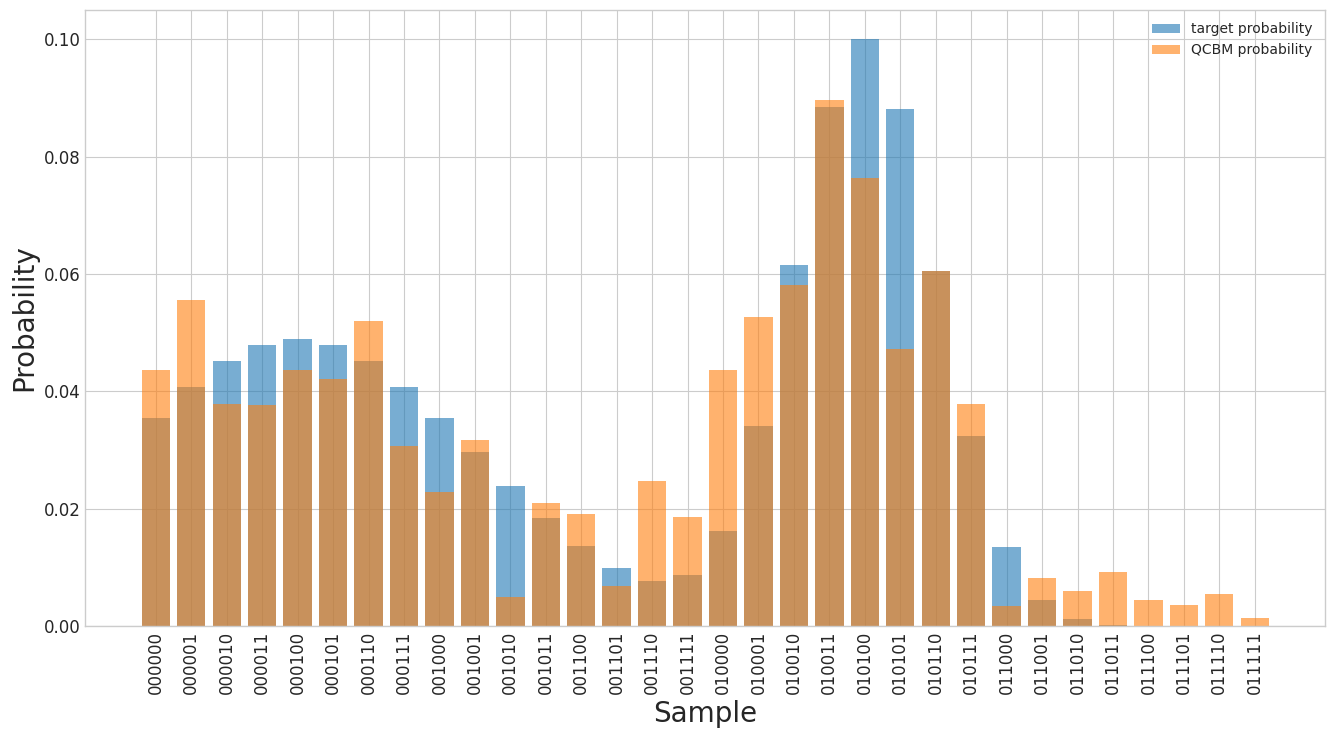

In [12]:
# Plotting the original probability distribution, and the QCBM prediction probability

device = LocalSimulator()
qcbm = QCBM(device, n_qubits, n_layers=n_layers, data=data)

qcbm_probs = qcbm.probabilities(job.result()["params"])

labels = ["{0:{fill}6b}".format(i, fill='0') for i in range(len(data))]

plt.bar(range(2 ** n_qubits), data, label="target probability", alpha=0.6)
plt.bar(range(2 ** n_qubits), qcbm_probs, label="QCBM probability", alpha=0.6)
plt.xticks([i for i in range(len(data))], labels, rotation='vertical', size=12)
plt.yticks(size=12)

plt.xlabel("Sample", size=20)
plt.ylabel("Probability", size=20)

fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.legend()
plt.show()

Great! As expected, the QCBM probability distribution closes matches the target distribution. 

In [13]:
print("Quantum Task Summary")
print(job.result()['task summary'])
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run quantum tasks in this hybrid job: {job.result()['estimated cost']} USD")

Quantum Task Summary
{}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run quantum tasks in this hybrid job: 0.0 USD


## Running different hyperparameters

One of the strengths of Braket Hybrid Jobs is the ability to submit and monitor many hybrid jobs simultaneously. We can use this to perform a grid search to find good hyperparameters. Below we initialize 4 unique hybrid jobs with different `n_layers`.

In [14]:
jobs = []

for n_layers in range(1, 5):
    print(f"Creating job with {n_layers} layers")
    tmp_job = train_circuit_hybrid_job(n_qubits, n_layers, n_iterations=10)

    jobs.append(tmp_job)

Creating job with 1 layers
Creating job with 2 layers
Creating job with 3 layers
Creating job with 4 layers


To check the results, we could load the results as we did before, or we could check the "Monitor" tab in the Braket Jobs dashboard in the AWS Console.

<!-- <div align="center"><img src="console_figures/hp_job_console.png"/></div> -->

In [15]:
%%time 
jobs[-1].result(); # wait for the last job to finish

CPU times: user 238 ms, sys: 10.8 ms, total: 249 ms
Wall time: 5min 42s


We can now plot the results from all the hyperparameters experiments once they finish. If the cell below does not work, wait a few minutes for metrics to load and try again.

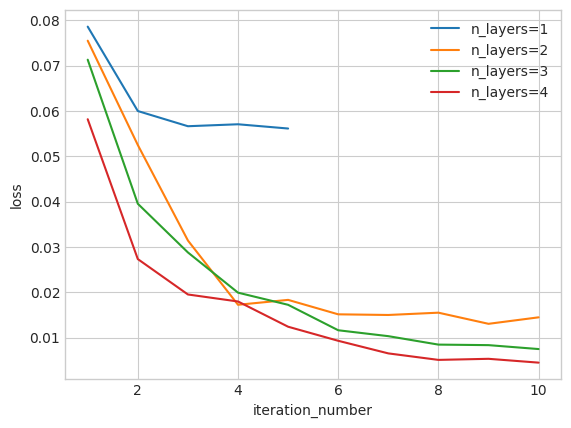

In [20]:
dfs = []
for i, j in enumerate(jobs):
    df = pd.DataFrame(j.metrics())
    df.sort_values(by=["iteration_number"])
    dfs.append(df)
    plt.plot(df["iteration_number"], df["loss"], label=f"n_layers={i+1}")

plt.xlabel("iteration_number")
plt.ylabel("loss")
plt.legend()
plt.show()

For the plots above, we see that the loss is much lower for `n_layers=3` and `n_layers=4`. We can conclude for 5 qubits, we need at least 3 layers in the QCBM to accurately learn the two-peak Gaussian data. 

In [17]:
for job in jobs:
    print("Quantum Task Summary")
    print(job.result()['task summary'])
    print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
    print(f"Estimated cost to run quantum tasks in this hybrid job: {job.result()['estimated cost']} USD")

Quantum Task Summary
{}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run quantum tasks in this hybrid job: 0.0 USD
Quantum Task Summary
{}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run quantum tasks in this hybrid job: 0.0 USD
Quantum Task Summary
{}
Note: Charges shown are estimates based on your Amazon Braket 

## Conclusion 

In this notebook, we submitted a single training hybrid job in Amazon Braket Hybrid Jobs. We then simultaneously submitted 4 new hybrid jobs with different hyperparameters to learn about the number of layers required in our circuit.

## References


[1] Benedetti, Marcello, Delfina Garcia-Pintos, Oscar Perdomo, Vicente Leyton-Ortega, Yunseong Nam, and Alejandro Perdomo-Ortiz. “A Generative Modeling Approach for Benchmarking and Training Shallow Quantum Circuits.” Npj Quantum Information 5, no. 1 (May 27, 2019): 1–9. https://doi.org/10.1038/s41534-019-0157-8.

[2] Liu, Jin-Guo, and Lei Wang. “Differentiable Learning of Quantum Circuit Born Machine.” Physical Review A 98, no. 6 (December 19, 2018): 062324. https://doi.org/10.1103/PhysRevA.98.062324.
